<a href="https://colab.research.google.com/github/zayo1511/ProyectoLabAnaDatFinDisInd/blob/main/Proyecto_Laboratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Paqeterías

In [1]:
!pip install semopy -q --disable-pip-version-check > /dev/null 2>&1

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from auto_ts import auto_timeseries
import statsmodels.api as sm
from semopy import Model, Optimizer, semplot

from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Colab Notebooks/Laboratorio de analisis de datos financieros y de diseño de indicadores/Proyecto/'

from sklearn import set_config
set_config(working_memory=1024)

Mounted at /content/drive


#Datos iniciales

In [3]:
df=pd.read_csv(data_path + 'satisfaction.csv')
df.head()

,CustomerID,Age,Gender,Income,VisitFrequency,AverageSpend,PreferredCuisine,TimeOfVisit,GroupSize,DiningOccasion,MealType,OnlineReservation,DeliveryOrder,LoyaltyProgramMember,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction,Rating
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,Takeaway,0,1,1,43.523929,2,5,4,0,3.67
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,Dine-in,0,0,0,57.524294,5,5,3,0,4.33
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,Dine-in,0,1,0,48.682623,3,4,5,0,4.00
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,Dine-in,0,0,0,7.552993,4,5,1,0,3.33
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,Takeaway,0,0,1,37.789041,2,3,5,0,3.33


## Manipulación de datos

In [4]:
df['Rating']=(df['ServiceRating']+df['FoodRating']+df['AmbianceRating'])/3
df.head()

,CustomerID,Age,Gender,Income,VisitFrequency,AverageSpend,PreferredCuisine,TimeOfVisit,GroupSize,DiningOccasion,MealType,OnlineReservation,DeliveryOrder,LoyaltyProgramMember,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction,Rating
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,Takeaway,0,1,1,43.523929,2,5,4,0,3.666667
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,Dine-in,0,0,0,57.524294,5,5,3,0,4.333333
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,Dine-in,0,1,0,48.682623,3,4,5,0,4.000000
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,Dine-in,0,0,0,7.552993,4,5,1,0,3.333333
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,Takeaway,0,0,1,37.789041,2,3,5,0,3.333333


In [5]:
def PromDet(AmbianceRating):
    if 	AmbianceRating == 5:
        return 'Promotor'
    elif AmbianceRating == 4:
        return 'Pasivo'
    else:
        return 'Detractor'

df['Pro/Det'] = df['AmbianceRating'].apply(PromDet)
df.head()

,CustomerID,Age,Gender,Income,VisitFrequency,AverageSpend,PreferredCuisine,TimeOfVisit,GroupSize,DiningOccasion,...,OnlineReservation,DeliveryOrder,LoyaltyProgramMember,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction,Rating,Pro/Det
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,...,0,1,1,43.523929,2,5,4,0,3.666667,Pasivo
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,...,0,0,0,57.524294,5,5,3,0,4.333333,Detractor
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,...,0,1,0,48.682623,3,4,5,0,4.000000,Promotor
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,...,0,0,0,7.552993,4,5,1,0,3.333333,Detractor
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,...,0,0,1,37.789041,2,3,5,0,3.333333,Promotor


#KPI

El KPI que nos sirve para poder ver como se va manejando la satisfacción de los clientes a traves del tiempo es el NPS, el cual nos ayudará a ver que tantas personas estan conformes y satisfechas con los productos y servicios de la empresa, además, de tomar en cuenta la satisfacción global del cliente con nuestra empresa. La variable que utilizaremos para poder medir este KPI será la variable de "Rating", la cual es calculada con base en el promedio de las 3 categorías de las que tenemos información: 'ServiceRating', 'FoodRating' y 'AmbianceRating'. Con base en el rating global se discrimina a los clientes clasificándolos en categorias de promotores, pasivos y detractores para poder contabilizar cuantos existen en cada grupo y obtener el valor del NPS.

In [6]:
ProDet = df['Pro/Det'].value_counts()
ProDet

,count
Pro/Det,
Detractor,890
Promotor,317
Pasivo,293


In [7]:
## NPS
NPS = (ProDet.iloc[1]- ProDet.iloc[0]) / ProDet.sum() * 100
NPS

-38.2

Como se puede observar, se tiene un KPI negativo, lo que indica que en la empresa hay más detractores que promotores. Segun el mercado, el benchmark para el NPS se clasifica con base en rangos.

- **$0 - 19$:** Bueno
- **$20 - 49$:** Favorable
- **$50 - 79$:** Excelente
- **$20 - 49$:** 'Clase mundial'

El hecho que el NPS de la empresa sea negativo significa que es algo muy malo, ya que de las categorías mencionadas la más baja comienza en 0. El objetivo de la empresa es aumentart la satisfacción de los clientes, obteniendo un mayopr número de promotores para hacer crecer su reconocimineto. Claramente minetras más alto pueda ser su NPS, mejor, no obstante el objetivo más proximo es el de convertir esta calificación a valores positivos.

#Visualización de variables

<Axes: xlabel='Gender'>

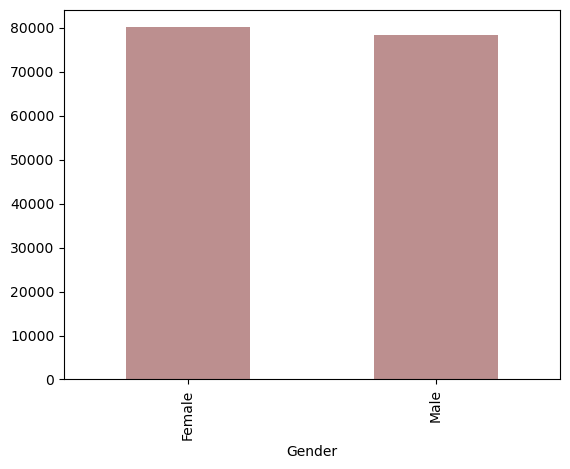

In [ ]:
df.groupby('Gender')['AverageSpend'].sum().plot(kind='bar', color='rosybrown')

<Axes: xlabel='VisitFrequency'>

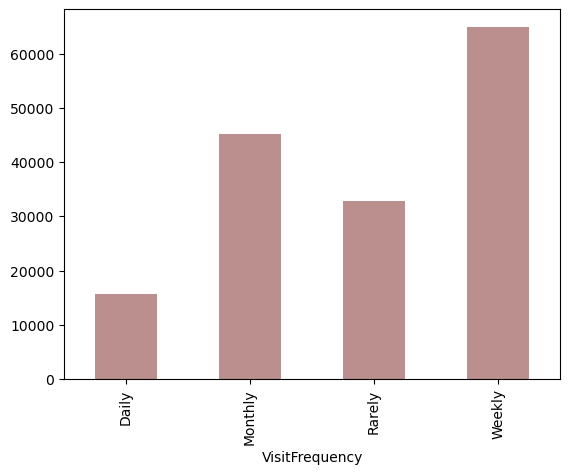

In [ ]:
df.groupby('VisitFrequency')['AverageSpend'].sum().plot(kind='bar', color='rosybrown')

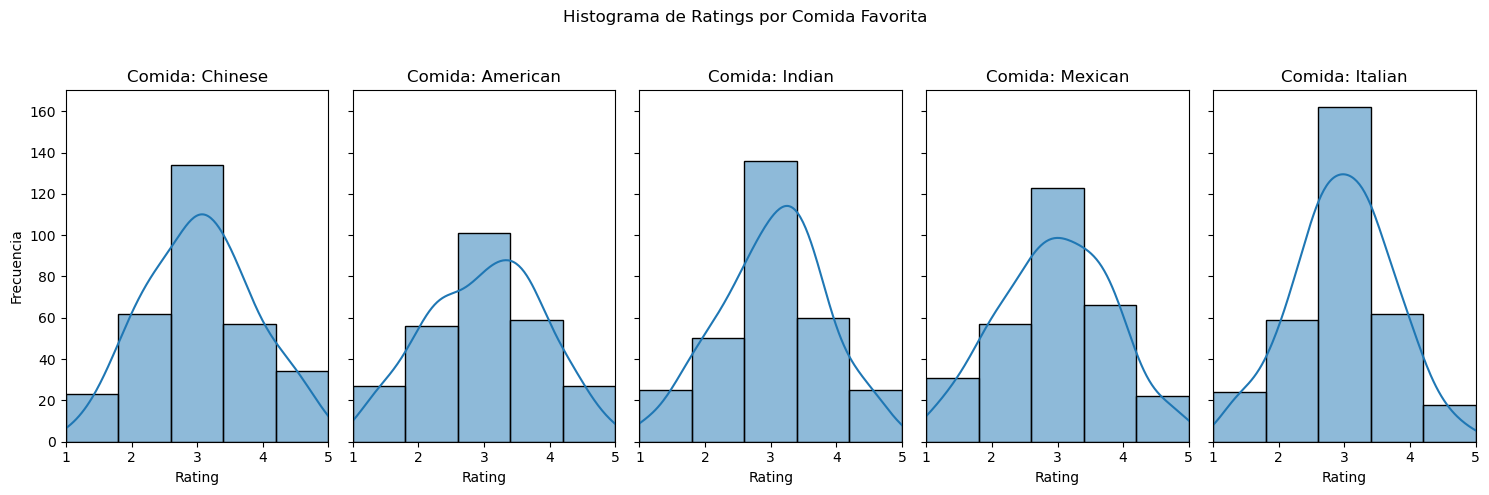

In [ ]:
# Configura el tamaño de la figura y la disposición de los subplots
comidas = df['PreferredCuisine'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(comidas), figsize=(15, 5), sharey=True)

# Itera sobre cada tipo de comida favorita y crea un histograma en cada subplot
for i, comida in enumerate(comidas):
    # Filtra el DataFrame para la comida actual
    data_comida = df[df['PreferredCuisine'] == comida]

    # Crea el histograma para esta comida
    sns.histplot(data_comida['Rating'], bins=5, kde=True, ax=axes[i])

    # Etiqueta el subplot
    axes[i].set_title(f'Comida: {comida}')
    axes[i].set_xlabel('Rating')
    axes[i].set_xlim(1, 5)

# Etiqueta general para el eje Y
axes[0].set_ylabel('Frecuencia')
plt.suptitle('Histograma de Ratings por Comida Favorita')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<Axes: xlabel='PreferredCuisine'>

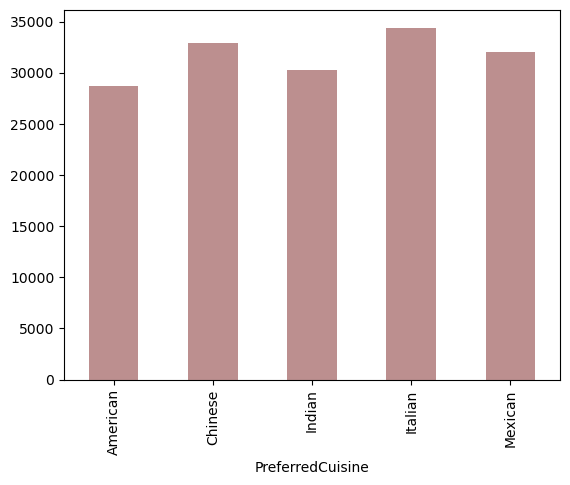

In [ ]:
df.groupby('PreferredCuisine')['AverageSpend'].sum().plot(kind='bar', color='rosybrown')

<Axes: xlabel='TimeOfVisit'>

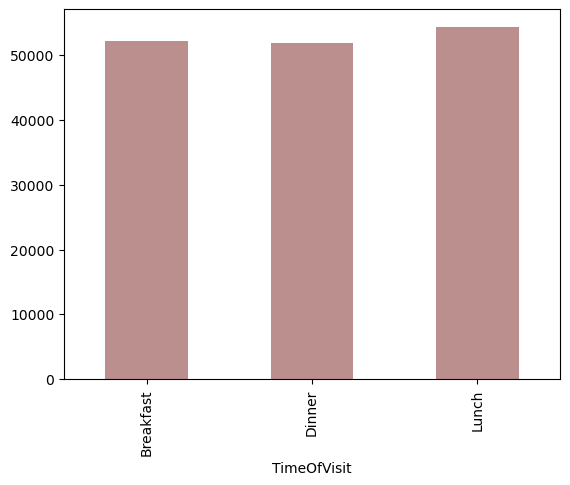

In [ ]:
df.groupby('TimeOfVisit')['AverageSpend'].sum().plot(kind='bar', color='rosybrown')

<Axes: xlabel='DiningOccasion'>

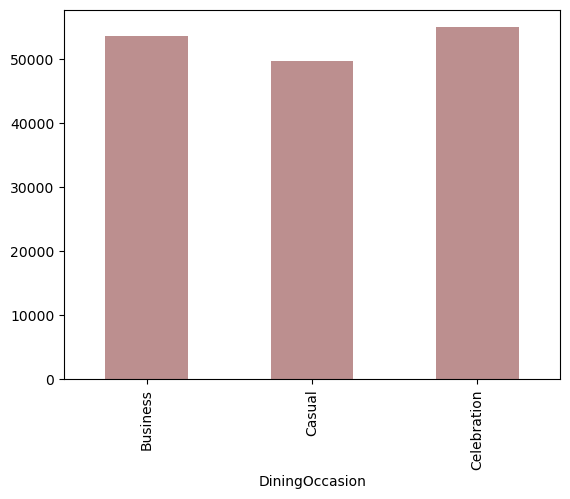

In [ ]:
df.groupby('DiningOccasion')['AverageSpend'].sum().plot(kind='bar', color='rosybrown')

#Clusters

In [8]:
# Separar variables numéricas y categóricas
numerical_features = ['Age', 'Income','GroupSize','WaitTime','AverageSpend']
categorical_features = ['VisitFrequency', 'PreferredCuisine', 'Gender','TimeOfVisit', 'DiningOccasion',]

# Hacer las categóricas dummies
encoded_features = pd.get_dummies(df[categorical_features],
               columns=categorical_features,
               drop_first=True)

# Estandarizar variables numéricas
data_to_model_standarized = StandardScaler().fit_transform(df[numerical_features])

# Hacer dataframe variables numéricas
data_to_model_df = pd.DataFrame(data_to_model_standarized,
                                columns=numerical_features).reset_index()

# Acomodar variables categóricas
encoded_features_df = encoded_features.reset_index()

# Juntar ambas variables
data_to_model = data_to_model_df.merge(encoded_features_df, on='index')
data_to_model = data_to_model.drop('index', axis=1)

data_to_model.head()

,Age,Income,GroupSize,WaitTime,AverageSpend,VisitFrequency_Monthly,VisitFrequency_Rarely,VisitFrequency_Weekly,PreferredCuisine_Chinese,PreferredCuisine_Indian,PreferredCuisine_Italian,PreferredCuisine_Mexican,Gender_Male,TimeOfVisit_Dinner,TimeOfVisit_Lunch,DiningOccasion_Casual,DiningOccasion_Celebration
0,-0.590289,-0.066593,-0.795670,0.776385,-1.532493,False,False,True,True,False,False,False,True,False,False,False,False
1,-1.659653,-1.108162,-1.577528,1.589960,0.188303,False,True,False,False,False,False,False,True,True,False,True,False
2,-0.189277,-0.057241,0.377116,1.076162,0.017070,False,False,True,False,False,False,False,False,True,False,False,True
3,-0.055607,0.284150,-1.577528,-1.313922,-1.224419,False,True,False,False,True,False,False,True,False,True,False,True
4,0.746416,-0.471175,-1.577528,0.443125,0.830333,True,False,False,True,False,False,False,False,False,False,False,False


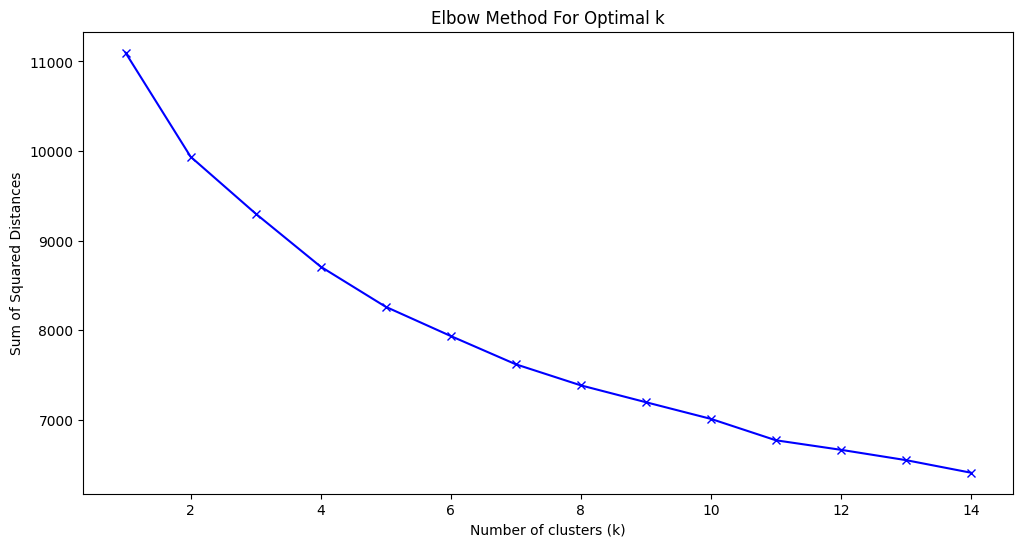

In [9]:
# Determinar el número óptimo de clusters usando el método del codo
sum_of_squared_distances = []
K = range(1, 15)  # Ajuste el rango según sea necesario
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(data_to_model)
    sum_of_squared_distances.append(km.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(12, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [10]:
# Aplicar K-means clustering para identificar segmentos de clientes
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(data_to_model)

# Agregar las etiquetas del cluster al DataFrame original para análisis
data_to_model['Cluster'] = labels
df['Cluster'] = labels
df.head()

,CustomerID,Age,Gender,Income,VisitFrequency,AverageSpend,PreferredCuisine,TimeOfVisit,GroupSize,DiningOccasion,...,DeliveryOrder,LoyaltyProgramMember,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction,Rating,Pro/Det,Cluster
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,...,1,1,43.523929,2,5,4,0,3.666667,Pasivo,1
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,...,0,0,57.524294,5,5,3,0,4.333333,Detractor,1
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,...,1,0,48.682623,3,4,5,0,4.000000,Promotor,0
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,...,0,0,7.552993,4,5,1,0,3.333333,Detractor,2
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,...,0,1,37.789041,2,3,5,0,3.333333,Promotor,1


In [11]:
def boxplot_clusters(columns):
    for col in columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x='Cluster', y=col, data=df, hue='Cluster', palette='Set3')
        plt.title(f'Boxplot de {col} por Clusters')
        plt.show()

        print()

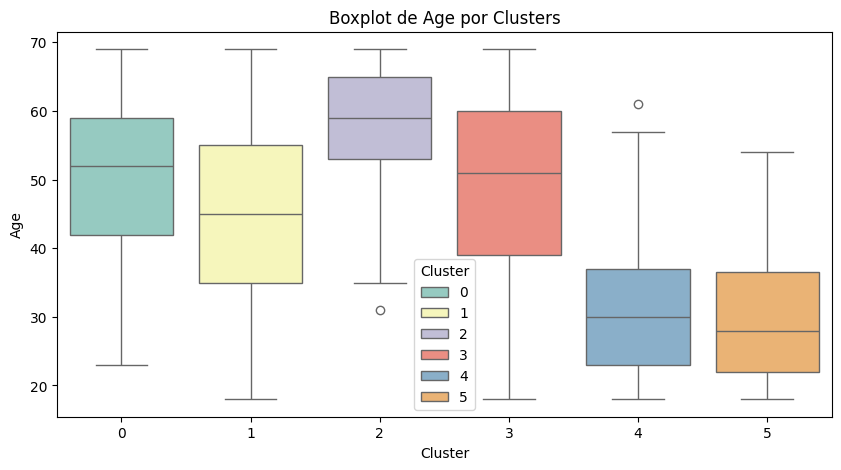

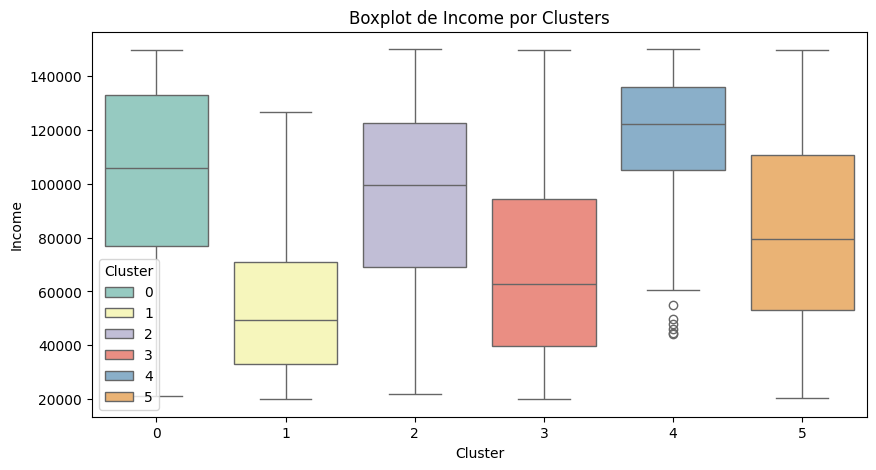

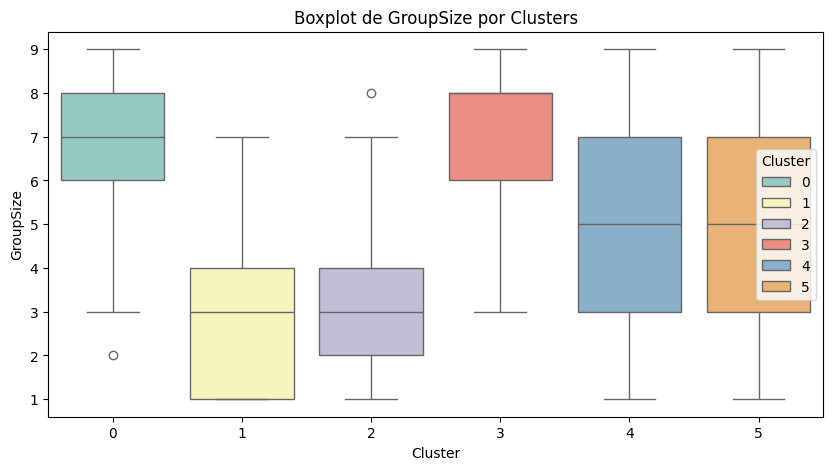

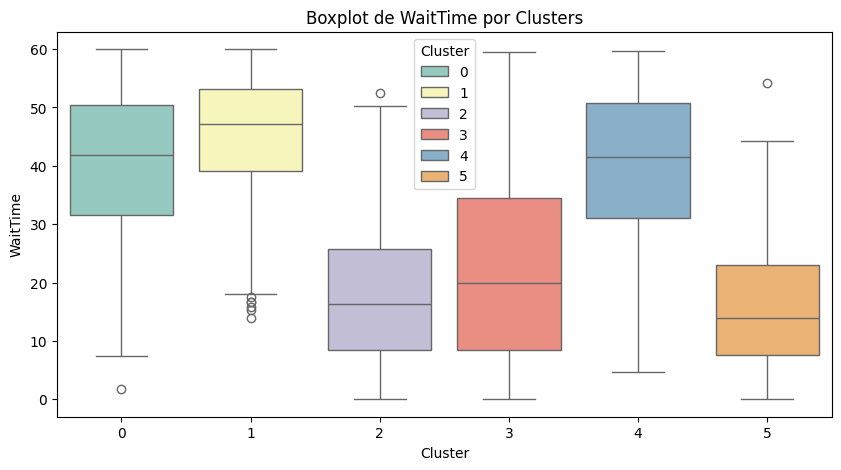

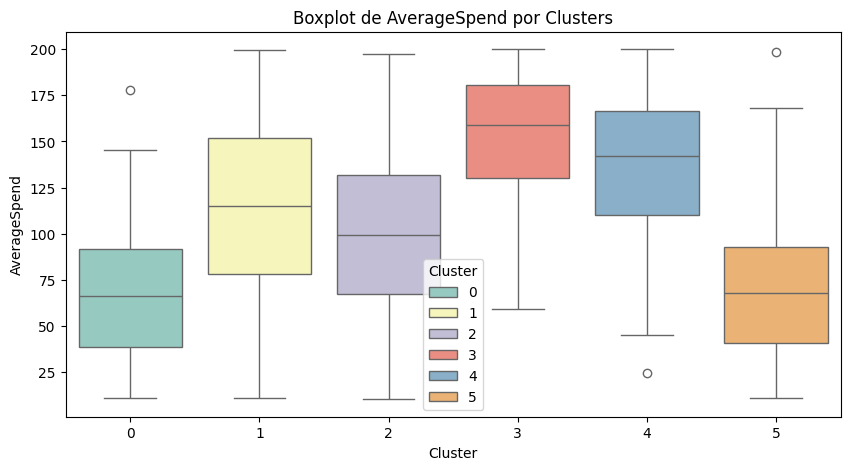

In [12]:
boxplot_clusters(numerical_features)

In [13]:
def barplot_clusters(columns):
    for col in columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(x='Cluster', hue=col, data=df, palette='Set3')
        plt.title('Count of Entries by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

        print()

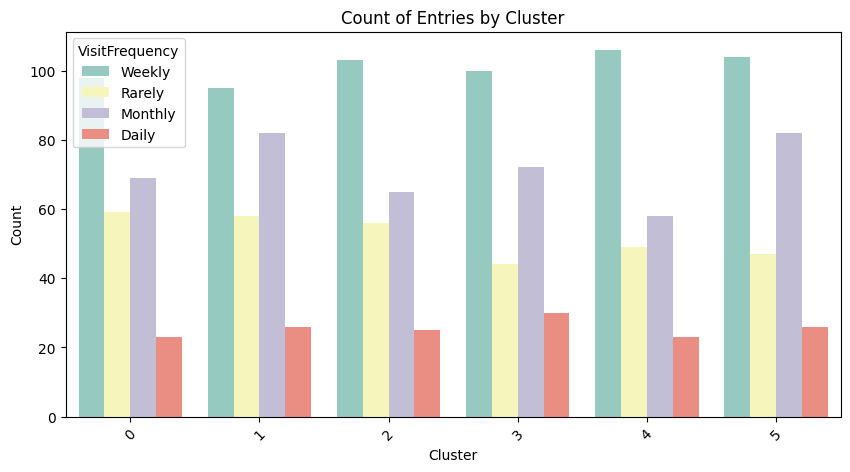

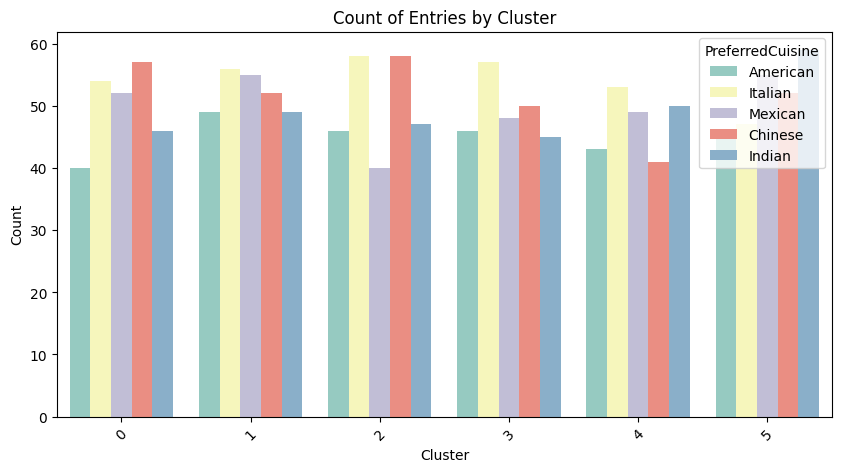

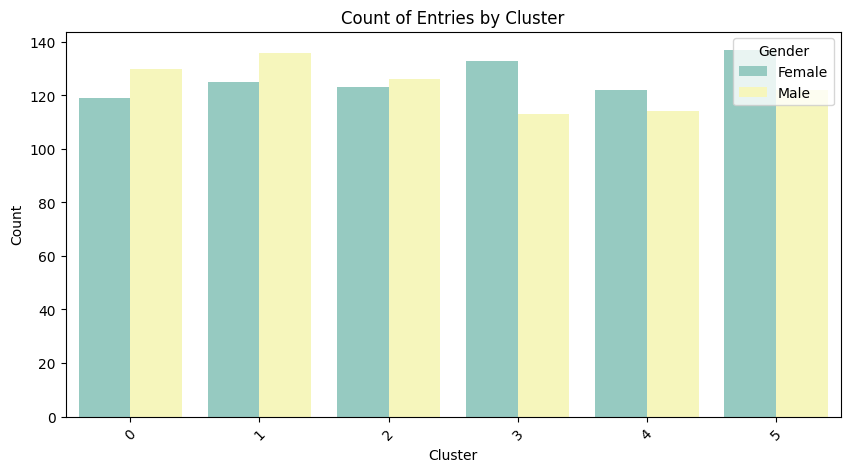

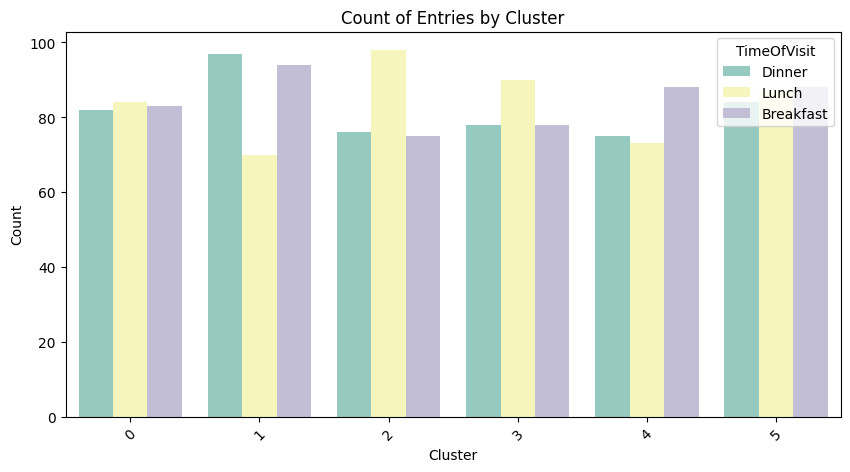

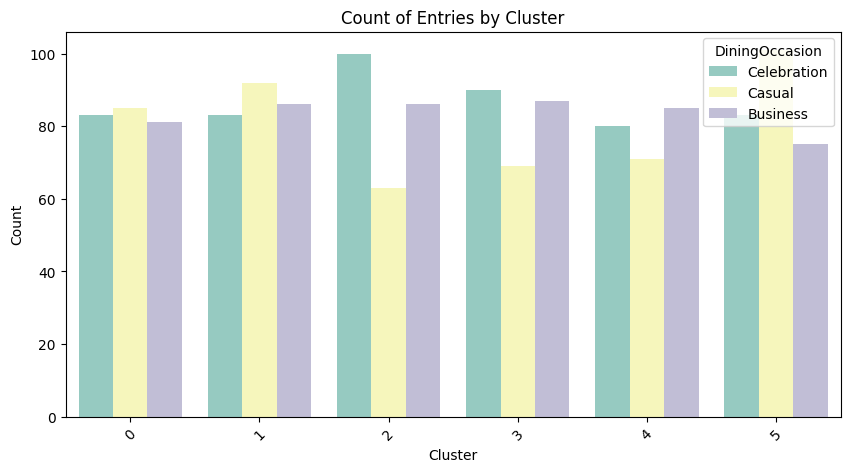

In [14]:
barplot_clusters(categorical_features)

#Regresión lineal

In [ ]:
categorical_features = ['VisitFrequency', 'PreferredCuisine', 'Gender','TimeOfVisit', 'DiningOccasion']
numerical_features = ['Age', 'Income','GroupSize','WaitTime','AverageSpend']

data_encoded = pd.get_dummies(df[['CustomerID'] + categorical_features], columns=categorical_features)


df_data_with_encoded = df[['CustomerID'] + numerical_features].merge(
    data_encoded, on = 'CustomerID'
)

cosa = pd.DataFrame(df_data_with_encoded.groupby('CustomerID')[df_data_with_encoded.columns[1:]].mean())
cosa.head()

,Age,Income,GroupSize,WaitTime,AverageSpend,VisitFrequency_Daily,VisitFrequency_Monthly,VisitFrequency_Rarely,VisitFrequency_Weekly,PreferredCuisine_American,...,PreferredCuisine_Italian,PreferredCuisine_Mexican,Gender_Female,Gender_Male,TimeOfVisit_Breakfast,TimeOfVisit_Dinner,TimeOfVisit_Lunch,DiningOccasion_Business,DiningOccasion_Casual,DiningOccasion_Celebration
CustomerID,,,,,,,,,,,,,,,,,,,,,
654,35.0,83380.0,3.0,43.523929,27.829142,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
655,19.0,43623.0,1.0,57.524294,115.408622,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
656,41.0,83737.0,6.0,48.682623,106.693771,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
657,43.0,96768.0,1.0,7.552993,43.508508,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
658,55.0,67937.0,1.0,37.789041,148.084627,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
todo = df.merge(cosa, on = 'CustomerID')
todo.head()

,CustomerID,Age_x,Gender,Income_x,VisitFrequency,AverageSpend_x,PreferredCuisine,TimeOfVisit,GroupSize_x,DiningOccasion,...,PreferredCuisine_Italian,PreferredCuisine_Mexican,Gender_Female,Gender_Male,TimeOfVisit_Breakfast,TimeOfVisit_Dinner,TimeOfVisit_Lunch,DiningOccasion_Business,DiningOccasion_Casual,DiningOccasion_Celebration
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2149,39,Male,114857,Monthly,163.015254,American,Lunch,2,Business,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1496,2150,37,Female,133506,Weekly,190.991911,Italian,Lunch,4,Casual,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1497,2151,46,Male,119159,Monthly,150.088605,American,Lunch,4,Casual,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1498,2152,24,Male,27970,Weekly,196.363626,Italian,Dinner,6,Casual,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
X = todo[['VisitFrequency_Monthly','VisitFrequency_Rarely','VisitFrequency_Weekly','VisitFrequency_Daily','Gender_Female','Gender_Male']]
y = todo['Rating']

In [ ]:
X = sm.add_constant(X)

# Ajustar el modelo usando OLS
model = sm.OLS(y, X)
results = model.fit()

# Mostrar el resumen del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.766
Date:                Tue, 12 Nov 2024   Prob (F-statistic):              0.133
Time:                        19:20:27   Log-Likelihood:                -1855.1
No. Observations:                1500   AIC:                             3720.
Df Residuals:                    1495   BIC:                             3747.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

# Forecast TS

<Axes: >

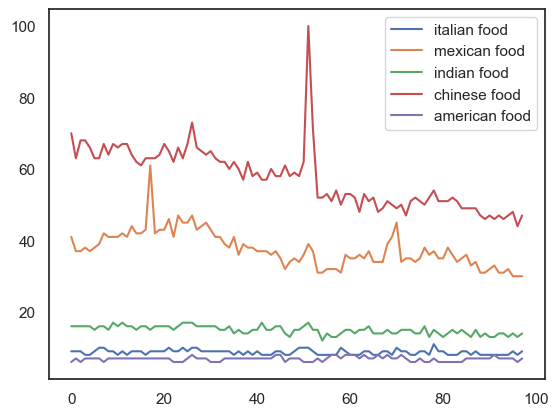

In [ ]:
df2=pd.read_csv('multiTimeline2.csv')
df2.plot()

## Forecast

In [ ]:
df3 = pd.read_csv('Ita.csv', parse_dates=['Fecha'])
df3.set_index('Fecha', inplace=True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2019-11-10 to 2024-11-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Ventas  262 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


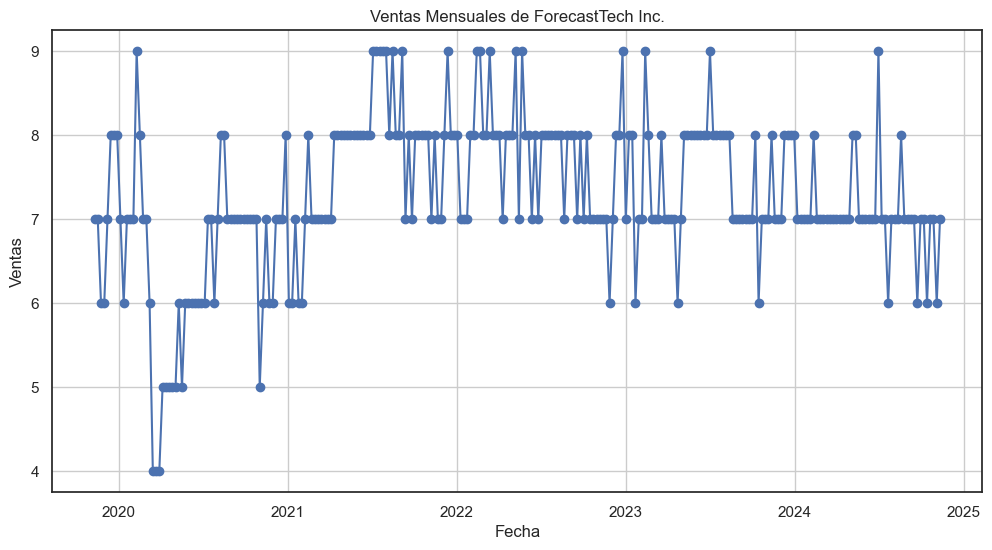

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df3.index, df3['Ventas'], marker='o')
plt.title('Ventas Mensuales de ForecastTech Inc.')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.show()

In [ ]:
model = auto_timeseries(
    score_type='rmse',       # Métrica de evaluación
    time_interval='W',       # Intervalo mensual
    non_seasonal_pdq=None,   # Para modelos SARIMAX
    seasonality=False,       # Deshabilitar búsqueda de estacionalidad (se puede cambiar)
    model_type='best',       # Seleccionar el mejor modelo
    verbose=2                # Nivel de verbosidad
)

Start of Fit.....
    Target variable given as = Ventas
Start of loading of data.....
    Inputs: ts_column = Fecha, sep = ,, target = ['Ventas']
    Using given input: pandas dataframe...
    train time series Fecha column is the index on test data...
    train data shape = (209, 1)
Alert: Could not detect strf_time_format of Fecha. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model


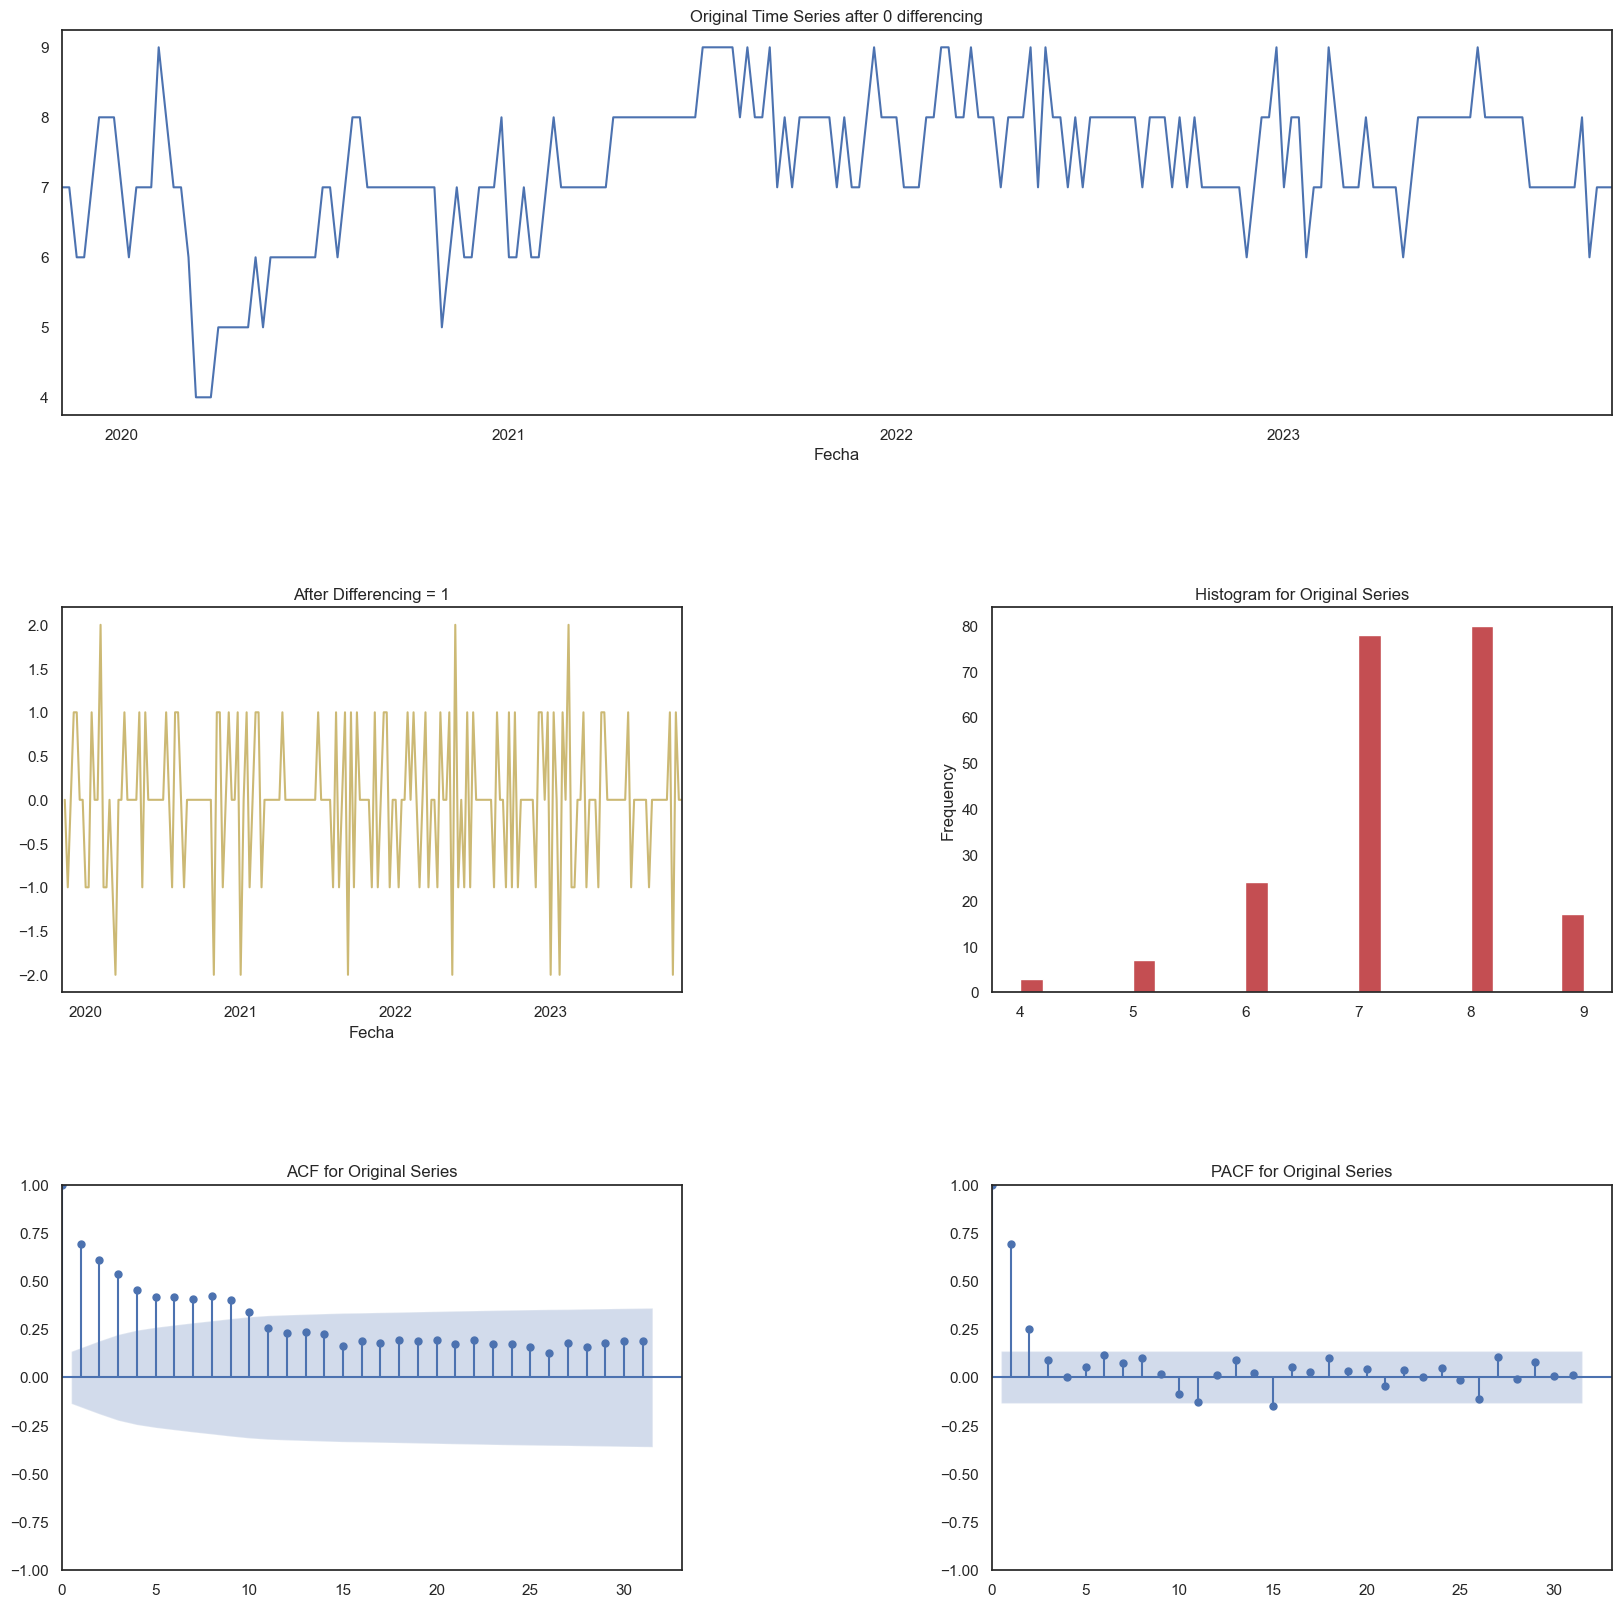

Time Interval is given as W
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(209, 2)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 184 Test Shape: 5


19:42:28 - cmdstanpy - INFO - Chain [1] start processing
19:42:28 - cmdstanpy - INFO - Chain [1] done processing
19:42:28 - cmdstanpy - INFO - Chain [1] start processing


    RMSE = 0.61
    Std Deviation of actuals = 0.00
    Normalized RMSE (as pct of std dev) = inf%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 189 Test Shape: 5


19:42:28 - cmdstanpy - INFO - Chain [1] done processing


    RMSE = 0.63
    Std Deviation of actuals = 0.40
    Normalized RMSE (as pct of std dev) = 158%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 194 Test Shape: 5


19:42:29 - cmdstanpy - INFO - Chain [1] start processing
19:42:29 - cmdstanpy - INFO - Chain [1] done processing
19:42:29 - cmdstanpy - INFO - Chain [1] start processing


    RMSE = 0.67
    Std Deviation of actuals = 0.49
    Normalized RMSE (as pct of std dev) = 138%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 199 Test Shape: 5


19:42:29 - cmdstanpy - INFO - Chain [1] done processing
19:42:30 - cmdstanpy - INFO - Chain [1] start processing


    RMSE = 0.51
    Std Deviation of actuals = 0.00
    Normalized RMSE (as pct of std dev) = inf%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 204 Test Shape: 5


19:42:30 - cmdstanpy - INFO - Chain [1] done processing


    RMSE = 0.64
    Std Deviation of actuals = 0.63
    Normalized RMSE (as pct of std dev) = 101%
Cross Validation window: 5 completed

-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 0.49
    MSE (Mean Squared Error = 0.38
    MAPE (Mean Absolute Percent Error) = 7%
    RMSE (Root Mean Squared Error) = 0.6154
    Normalized RMSE (MinMax) = 21%
    Normalized RMSE (as Std Dev of Actuals)= 95%
Time Taken = 3 seconds


19:42:30 - cmdstanpy - INFO - Chain [1] start processing
19:42:30 - cmdstanpy - INFO - Chain [1] done processing


  End of Prophet Fit


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 184 Test Shape: 5

    Finding the best parameters using AutoArima:
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=441.465, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=419.609, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=410.481, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=439.473, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=406.459, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=405.628, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=416.238, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=407.271, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=407.370, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,1,0)(0,

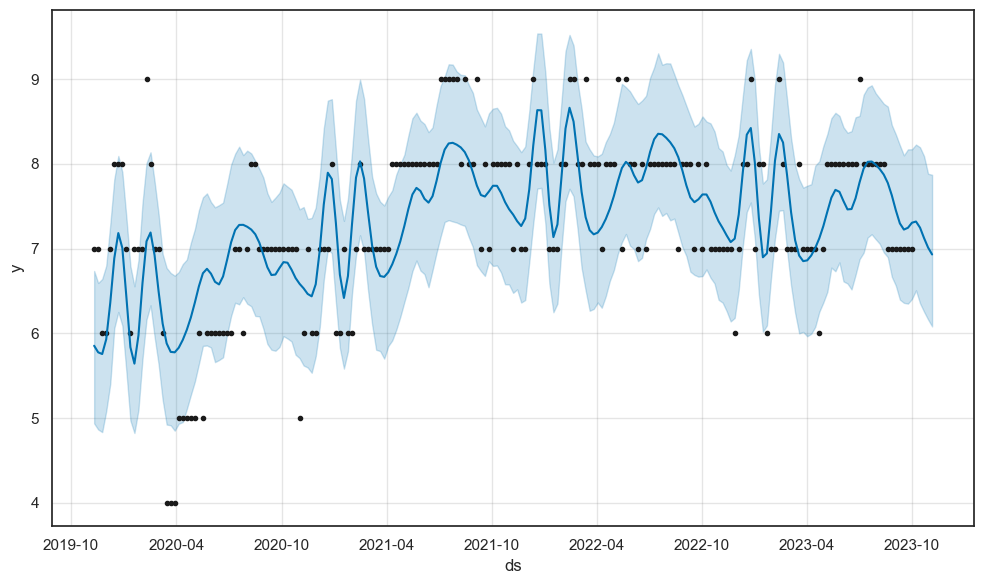

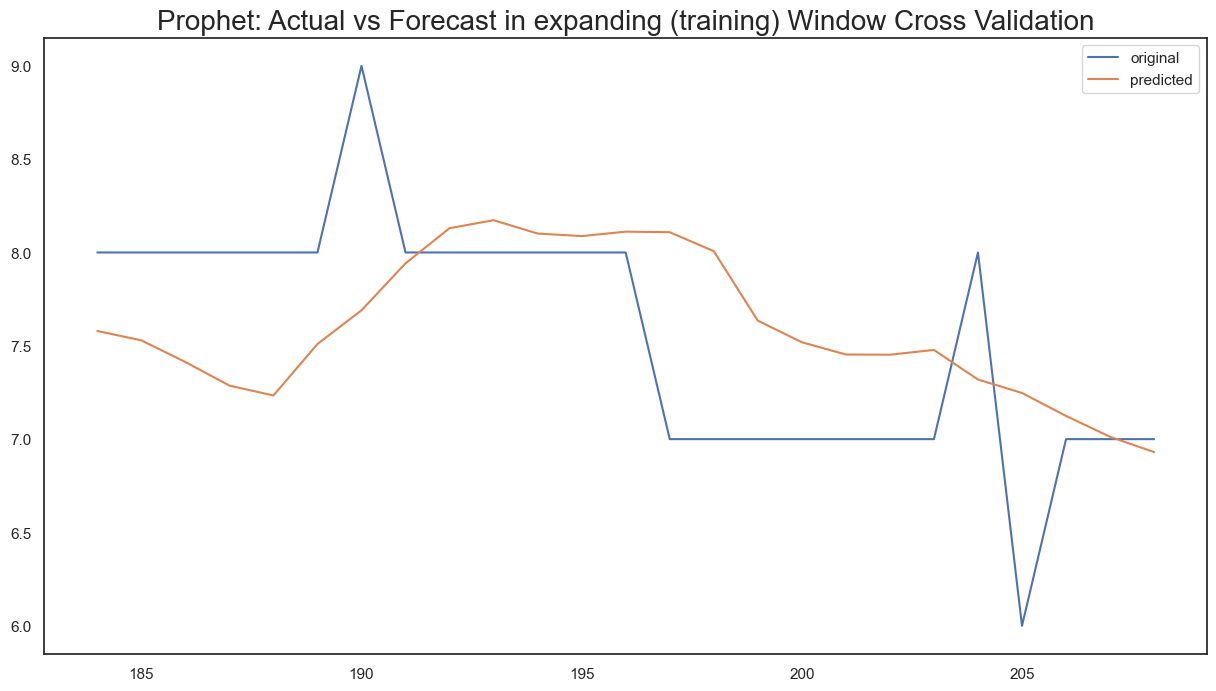

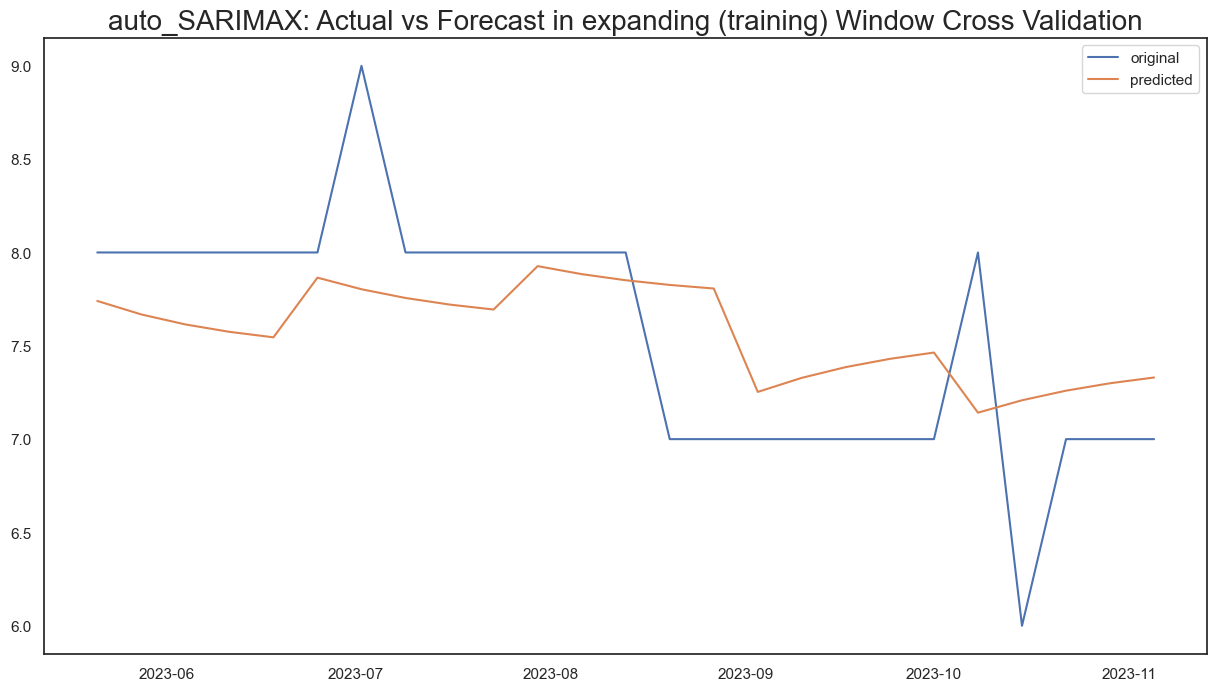

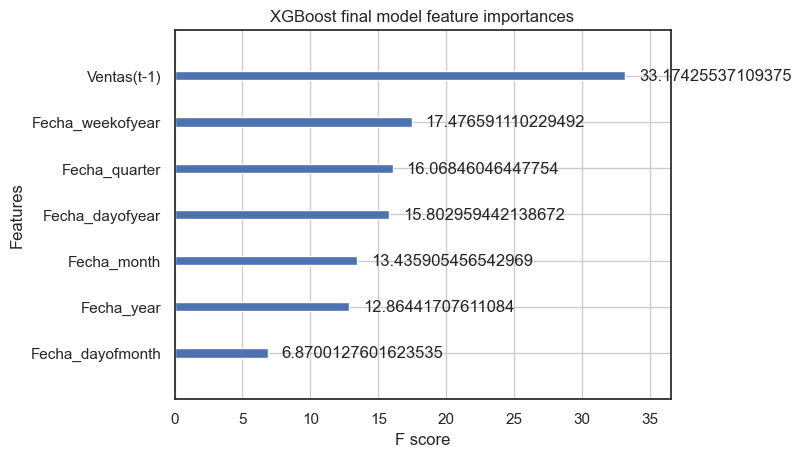

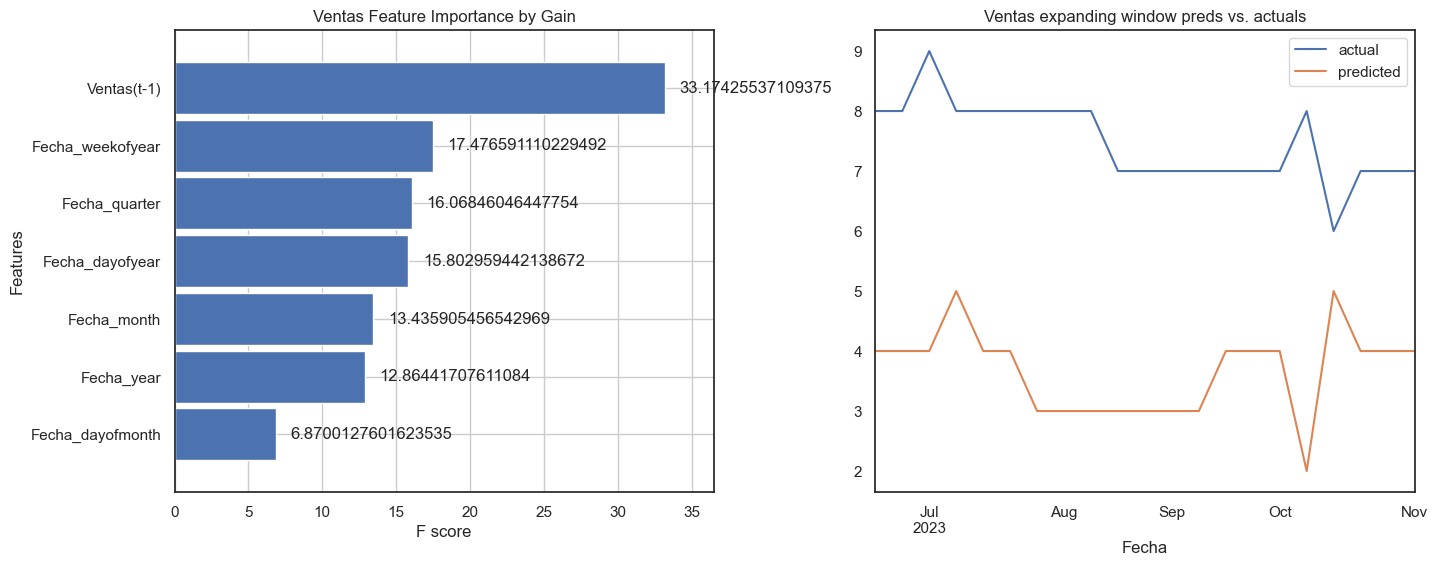

In [ ]:
train_size = int(0.8 * len(df3))
train_df = df3[:train_size]
test_df = df3[train_size:]

model.fit(
    traindata=train_df,
    ts_column=train_df.index.name,
    target='Ventas'
)

In [ ]:
forecast = model.predict(testdata=test_df)
forecast.head()

Predicting using test dataframe as input for auto_SARIMAX model


Ventas,yhat,mean_se,mean_ci_lower,mean_ci_upper
2023-11-12,6.968616,0.704173,5.588462,8.348770
2023-11-19,6.949611,0.786252,5.408586,8.490637
2023-11-26,6.933261,0.830106,5.306284,8.560238
2023-12-03,6.917682,0.863791,5.224683,8.610680
2023-12-10,6.902256,0.893862,5.150319,8.654192


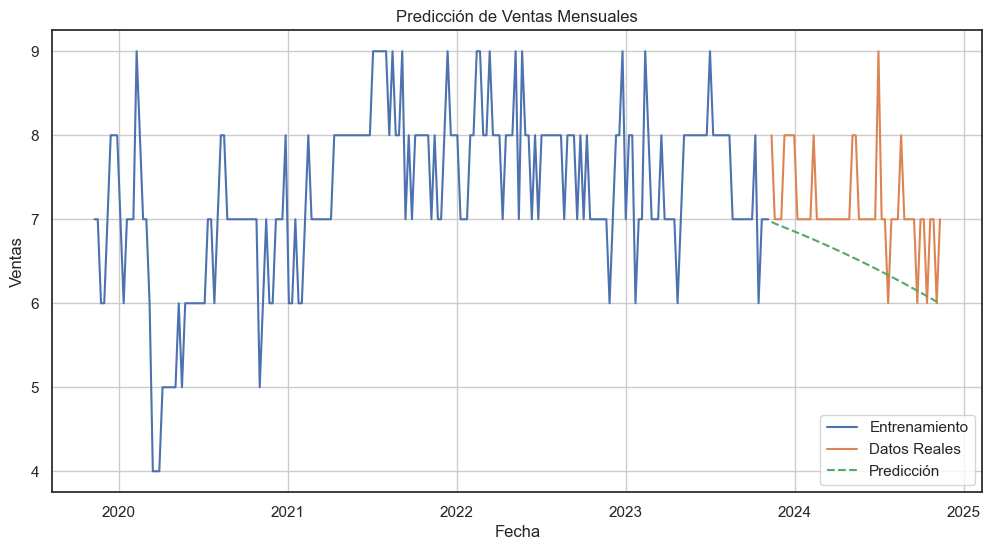

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_df.index, train_df['Ventas'], label='Entrenamiento')
plt.plot(test_df.index, test_df['Ventas'], label='Datos Reales')
plt.plot(test_df.index, forecast['yhat'], label='Predicción', linestyle='--')
plt.title('Predicción de Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

Predicting using test dataframe as input for auto_SARIMAX model


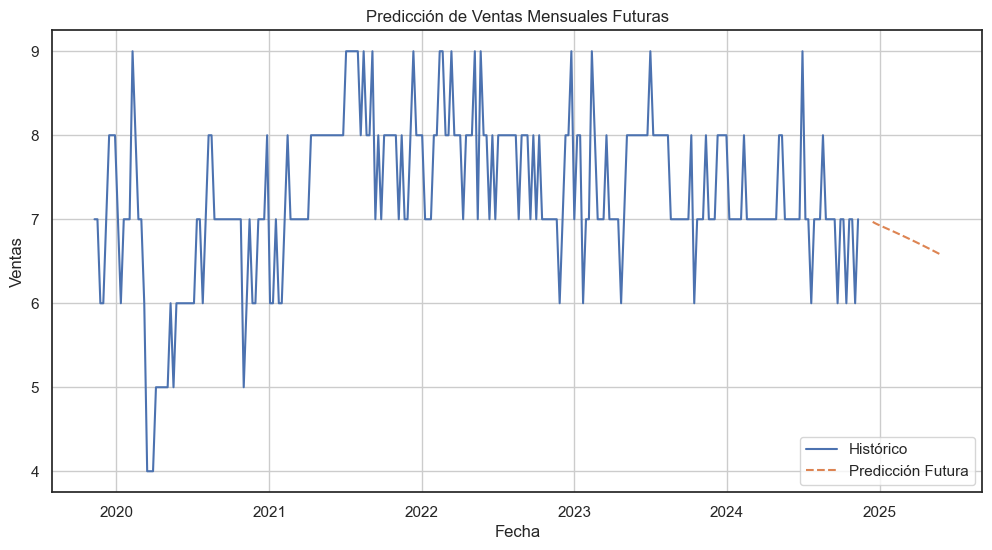

In [ ]:
future_periods = 24
last_date = df3.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_periods, freq='W')

future_df = pd.DataFrame(index=future_dates)
future_forecast = model.predict(testdata=future_df)

plt.figure(figsize=(12,6))
plt.plot(df3.index, df3['Ventas'], label='Histórico')
plt.plot(future_dates, future_forecast['yhat'], label='Predicción Futura', linestyle='--')
plt.title('Predicción de Ventas Mensuales Futuras')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

# SEM

In [15]:
model_desc = """
# Latent Variables
Satisfaccion_cliente =~ ServiceRating + FoodRating + AmbianceRating + WaitTime
Frecuencia_visita =~ VisitFrequency + AverageSpend + DiningOccasion

# Regressions
NPS ~ Satisfaccion_cliente + Frecuencia_visita

# Variances and Covariances
Satisfaccion_cliente ~~ Frecuencia_visita
"""

np.random.seed(42)

# Normalizar valores con MinMaxScaler
scaler = StandardScaler()

# 1. Variables relacionadas con Satisfaccion_cliente
ServiceRating = scaler.fit_transform(df['ServiceRating'].values.reshape(-1, 1))

FoodRating = scaler.fit_transform(df['FoodRating'].values.reshape(-1, 1))

AmbianceRating = scaler.fit_transform(df['AmbianceRating'].values.reshape(-1, 1))

WaitTime = scaler.fit_transform(df['WaitTime'].values.reshape(-1, 1))

# 2. Variables relacionadas con Frecuencia_visita
# Transformar la columna 'VisitFrequency' en valores numéricos
df['VisitFrequency_numeric'] = df['VisitFrequency'].apply(lambda x: 1 if x == 'Daily' else (2 if x == 'Weekly' else (3 if x == 'Monthly' else 4)))
VisitFrequency = scaler.fit_transform(df['VisitFrequency_numeric'].values.reshape(-1, 1))

AverageSpend = scaler.fit_transform(df['AverageSpend'].values.reshape(-1, 1))

# Transformar la columna 'DiningOccasion' en valores numéricos
df['DiningOccasion_numeric'] = df['DiningOccasion'].apply(lambda x: 1 if x == 'Casual' else (2 if x == 'Business' else 3))
DiningOccasion = scaler.fit_transform(df['DiningOccasion_numeric'].values.reshape(-1, 1))

# 3. Crear la variable NPS influenciada por Satisfaccion_cliente y Experiencia_compra
NPS = scaler.fit_transform(((ServiceRating + FoodRating + AmbianceRating + WaitTime)*0.6 + (VisitFrequency + AverageSpend + DiningOccasion)*0.4).flatten().reshape(-1, 1))

# 4. Crear DataFrame final con todas las variables relevantes
data_sem = pd.DataFrame({
    "ServiceRating": ServiceRating.flatten(),
    "FoodRating": FoodRating.flatten(),
    "AmbianceRating": AmbianceRating.flatten(),
    "WaitTime": WaitTime.flatten(),
    "VisitFrequency": VisitFrequency.flatten(),
    "AverageSpend": AverageSpend.flatten(),
    "DiningOccasion": DiningOccasion.flatten(),
    "NPS": NPS.flatten()  # Convertir NPS a una lista unidimensional
})

# Ajustar el modelo SEM a los datos generados
mod = Model(model_desc)
res_opt = mod.fit(data_sem)
estimates = mod.inspect()

# Imprimir los resultados del ajuste del modelo
print(estimates)

                    lval  op                  rval  Estimate  Std. Err  \
0          ServiceRating   ~  Satisfaccion_cliente  1.000000         -   
1             FoodRating   ~  Satisfaccion_cliente  0.980176  0.071298   
2         AmbianceRating   ~  Satisfaccion_cliente  0.960522  0.070781   
3               WaitTime   ~  Satisfaccion_cliente  0.979714  0.071277   
4         VisitFrequency   ~     Frecuencia_visita  1.000000         -   
5           AverageSpend   ~     Frecuencia_visita  1.493667  0.160276   
6         DiningOccasion   ~     Frecuencia_visita  1.040719  0.130628   
7                    NPS   ~  Satisfaccion_cliente  1.630735  0.260044   
8                    NPS   ~     Frecuencia_visita  0.985031  0.409157   
9   Satisfaccion_cliente  ~~     Frecuencia_visita  0.109557  0.013729   
10  Satisfaccion_cliente  ~~  Satisfaccion_cliente  0.210425  0.024266   
11     Frecuencia_visita  ~~     Frecuencia_visita  0.091267  0.018801   
12        AmbianceRating  ~~        Am

In [16]:
print(res_opt)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 2.793
Number of iterations: 29
Params: 0.980 0.961 0.980 1.494 1.041 1.631 0.985 0.110 0.210 0.806 0.797 0.901 0.798 0.091 0.000 0.790 0.909 0.798


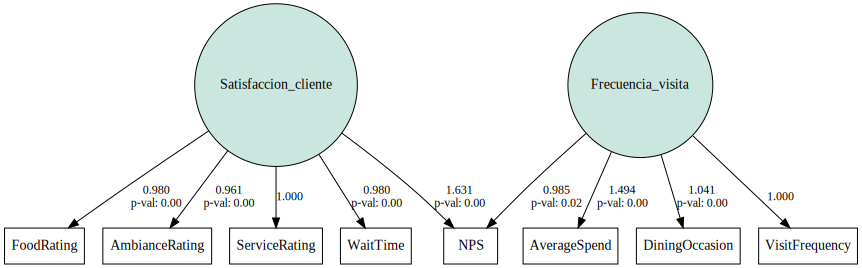

In [17]:
g = semplot(mod, "pd.png")
g

### Análisis del Modelo SEM y Resultados

Este análisis está basado en un modelo de ecuaciones estructurales (SEM) que mide la influencia de dos variables latentes (**Satisfacción del cliente** y **Frecuencia de visita**) sobre el **NPS**. A continuación, se presenta un resumen de los resultados y las conclusiones derivadas del modelo.

#### Estimaciones de Parámetros

1. **Relaciones entre Variables Latentes y Observadas**:
   - **ServiceRating** (Satisfaccion_cliente): Establecido como referencia con un valor de 1.0 (por convención en SEM).
   - **FoodRating** (Satisfaccion_cliente): Estima una carga factorial de **0.983**, lo que indica una fuerte relación con la variable latente **Satisfacción del cliente**.
   - **AmbianceRating** (Satisfaccion_cliente): Tiene una carga factorial de **0.962**, también indicando una relación fuerte con **Satisfacción del cliente**, aunque un poco menor que **AmbianceRating**.
   - **WaitTime** (Satisfaccion_cliente): Estima una carga factorial de **1.022**, lo que indica la relación más fuerte con la variable latente **Satisfacción del cliente**.
   - **VisitFrequency** (Frecuencia_visita): Establecido como referencia con un valor de 1.0 (por convención en SEM).
   - **DiningOccasion** (Frecuencia_visita): Carga factorial de **1.016**, lo que indica una relación fuerte con la **Frecuencia de visita**.
   - **AverageSpend** (Frecuencia_visita): Carga factorial de **1.118**, lo que indica una relación fuerte con la variable latente **Frecuencia de visita**, mayor a la relación de **DiningOccasion**

2. **Relaciones entre las Variables Latentes y el NPS**:
   - **Satisfaccion_cliente** → **NPS**: Coeficiente de **1.697**, con una significancia muy alta (*p-value = 0.00*). Esto indica que, a mayor satisfacción del cliente, mayor es el NPS.
   - **Frecuencia_visita** → **NPS**: Coeficiente de **0.895**, muy significativo (*p-value = 0.00*), sugiriendo que la frecuencia de visita tiene una influencia importante sobre el NPS, aunque menor que la de la satisfacción del cliente.

3. **Covarianzas**:
   - **Satisfaccion_cliente** y **Frecuencia_visita** están poco correlacionadas (**0.1026**). Esta relación es estadísticamente significativa (*p-value = 0.00*).
   - La varianza residual de **NPS** es practicamente **0**, lo que indica que el modelo no captura la varianza en NPS, lo que dice, que aún hay factores no explicados que influyen.

#### Métricas de Ajuste del Modelo

El ajuste del modelo  fue satisfactorio, con un valor objetivo de **2.816** después de 32 iteraciones utilizando el método de optimización **SLSQP**. El modelo se ajustó correctamente a los datos, lo que se refleja en el éxito del proceso de optimización.

#### Interpretación General

- **Satisfacción del cliente** y **Frecuencia de visita** son dos factores clave que explican el **NPS** en la empresa. Ambos factores tienen un impacto positivo, siendo la **Satisfaccion del cliente** el factor más importante en términos de influencia sobre el NPS.

- Las relaciones entre las variables latentes y sus indicadores observados son fuertes y significativas, lo que valida la construcción teórica de las variables latentes de **Satisfacción del cliente** y **Frecuencia de visita**.

#### Conclusiones

Este modelo de ecuaciones estructurales ha demostrado ser útil para entender cómo factores complejos como la **Satisfacción del cliente** y **Frecuencia de visita** impactan en el NPS. La empresa pueden enfocarse en mejorar estos dos aspectos, para aumentar su NPS. Además, las intervenciones en mejorar su enfoque por Ratings pueden ser prioritarias, dado su peso en los constructos latentes.

Este análisis proporciona una base sólida para la toma de decisiones basada en datos dentro de la empresa, dirigiendo los esfuerzos hacia las áreas que mayor impacto tienen en el NPS.

# AB Testing (propuestas)

La empresa cuenta con un programa de fidelidad (LoyaltyProgramMember). Además, tienen clasificados a los clientes que tiene una satisfacción alta. Se podría probar como el aumentar la alta satisfacción de los clientes aumenta en su programa de fidelidad. Algunos de los anális que podría hacer la empresa, son:

- ¿Si es más alta la satisfacción promedio de los clientes, habrán más personas dentro del programa de fidelidad?

    Hipótesis:
$$H_0: \Delta \leq 30\%$$
$$H_1: \Delta > 30\%$$
&nbsp;Donde $\Delta$ el la diferencia de satisfacción promedio de los clientes.

Suponiendo que la tasa de conversión fue del 10\%, la muestra necesaria para realizar la prueba es:
$$
n = \frac{2 \times (Z_{\alpha/2} + Z_{\beta})^2 \times p(1-p)}{(p_1 - p_2)^2}
$$

In [18]:
n1 = (2*((1.96+0.84)**2)*0.1*(1-0.1))/(0.3)**2
n1

15.679999999999998

- ¿Ser miembro del programa de fidelidad aumenta la proporción de clientes con satisfaccióin alta?

    Hipótesis:
$$H_0: \Delta \leq 10\%$$
$$H_1: \Delta > 10\%$$
&nbsp;Donde $\Delta$ el la diferencia en la proporción de miembros en el programa de fidelidad

Suponiendo que el aumento de satisfacción fue del 25\%, la muestra necesaria para realizar la prueba es:
$$
n = \frac{2 \times (Z_{\alpha/2} + Z_{\beta})^2 \times p(1-p)}{(p_1 - p_2)^2}
$$

In [19]:
n2 = (2*((1.96+0.84)**2)*0.25*(1-0.25))/(0.1)**2
n2

293.9999999999999

# Recomendación de uso de AI